### Before running this, make sure the GPU is enabled. To do that, go to **Runtime->Change runtime type** and select **T4 GPU** under **Hardware Accelerator**.

##**Hello World in Python**
Juypter notebook natively support Python code in the cells. The following is a Hello-world example which you can run by clicking the `play` icon on the left of the cell.

# No need main entry function

In [ ]:
print("Hello world!")

Hello world!


# Functions

In [ ]:
def add_2_nums(a, b):
  return a + b

print(add_2_nums(1,2))

3


In [ ]:
msg_to_print = 'Hello, world!'
print(msg_to_print)

Hello, world!


##**Hello World in C/C++**
The notebook also supports programming in other languages, but it requires a few additional steps. Here’s what you need to do:

1.   **Write and save the code**: Use the `%%writefile` magic command to write and save your code into the current working directory.

2.   **Compile/build the code**: Compile or build the code into an executable file using your preferred compiler. For C/C++ programming, you can use compilers like `clang`, `nvcc`, `gcc`, or `g++`.

3.   **Run the executable**: Execute the compiled file.

Below is an example of a C/C++ program saved as a `.cu` file. After clicking the play icon, follow the steps shown in the image to see the saved file.

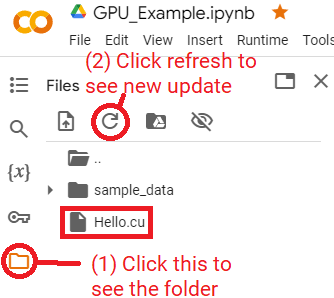

In [ ]:
# (1) Save the content in this cell using the `%%writefile` magic command
%%writefile Hello.cu
#include <iostream>

using namespace std;

int main() {
  cout << "Hello, Fu Lim!" << endl;
  return 0;
}

Writing Hello.cu


! = run bash commmand

# Nvidia C Compiler

In [ ]:
# (2) Compile the code into an executable file called `Hello.out` using NVCC compiler
!nvcc Hello.cu -o Hello.out

# C++ Compiler

In [ ]:
!g++ Hello.cu -o Hello.out

/usr/bin/ld:Hello.cu: file format not recognized; treating as linker script
/usr/bin/ld:Hello.cu:3: syntax error
collect2: error: ld returned 1 exit status


# C Compiler

In [ ]:
!gcc Hello.cu -o Hello.out

/usr/bin/ld:Hello.cu: file format not recognized; treating as linker script
/usr/bin/ld:Hello.cu:3: syntax error
collect2: error: ld returned 1 exit status


# C Compiler

In [ ]:
!clang Hello.cu -o Hello.out

clang: warning: CUDA version is newer than the latest supported version 11.5 [-Wunknown-cuda-version]
In file included from <built-in>:1:
In file included from /usr/lib/llvm-14/lib/clang/14.0.0/include/__clang_cuda_runtime_wrapper.h:365:
/usr/lib/llvm-14/lib/clang/14.0.0/include/__clang_cuda_texture_intrinsics.h:696:13: error: 
      no template named 'texture'
            texture<__DataT, __TexT, cudaReadModeNormalizedFloat> __handle,
            ^
/usr/lib/llvm-14/lib/clang/14.0.0/include/__clang_cuda_texture_intrinsics.h:709:13: error: 
      no template named 'texture'
            texture<__DataT, __TexT, cudaReadModeElementType> __handle,
            ^
2 errors generated when compiling for sm_35.


In [ ]:
# (3) Run the executable file
!./Hello.out

/bin/bash: line 1: ./Hello.out: No such file or directory


##**Simple CUDA Exercise**
Here is the CUDA exercise in Practial P3. The CUDA related code can be found in this [guide](https://medium.com/@aviatorx/c-and-cuda-project-visual-studio-d07c6ad771e3).

In [ ]:
%%writefile cuda_kernel.cuh
#pragma once
void parallel_vector_add(double* A, double* B, double* C, int arraySize);

Writing cuda_kernel.cuh


In [ ]:
%%writefile ParallelVectorAdd.cu
#include <cuda_runtime.h>
#include "cuda_kernel.cuh"

__global__ void vectorAdditionKernel(double* A, double* B, double* C, int arraySize) {
    // Get thread ID.
    int threadID = blockDim.x * blockIdx.x + threadIdx.x;

    // Check if thread is within array bounds.
    if (threadID < arraySize) {
        // Add a and b.
        C[threadID] = A[threadID] + B[threadID];
    }
}

/**
 * Wrapper function for the CUDA kernel function.
 * @param A Array A.
 * @param B Array B.
 * @param C Sum of array elements A and B directly across.
 * @param arraySize Size of arrays A, B, and C.
 */
void parallel_vector_add(double* A, double* B, double* C, int arraySize) {

    // Initialize device pointers.
    double* d_A, * d_B, * d_C;

    // Allocate device memory.
    cudaMalloc((void**)&d_A, arraySize * sizeof(double));
    cudaMalloc((void**)&d_B, arraySize * sizeof(double));
    cudaMalloc((void**)&d_C, arraySize * sizeof(double));

    // Transfer arrays a and b to device.
    cudaMemcpy(d_A, A, arraySize * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, arraySize * sizeof(double), cudaMemcpyHostToDevice);

    // Calculate blocksize and gridsize.
    dim3 blockSize(512, 1, 1);
    dim3 gridSize(arraySize / 512 + 1, 1);

    // Launch CUDA kernel.
    vectorAdditionKernel <<<gridSize, blockSize >>> (d_A, d_B, d_C, arraySize);

    // Copy result array c back to host memory.
    cudaMemcpy(C, d_C, arraySize * sizeof(double), cudaMemcpyDeviceToHost);

    // cudaFree d_A, d_B, and d_C here
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

Writing ParallelVectorAdd.cu


In [ ]:
%%writefile CudaTestrun.cu
// CudaTestRun.cpp : This file contains the 'main' function. Program execution begins and ends there.

#include <iostream>
#include <stdio.h>
#include "cuda_kernel.cuh"

#define SIZE (1024 * 1024)

void serial_vector_add(double* a, double* b, double* c, int n) {
    int i;

    //double time = omp_get_wtime();
    for (i = 0; i < n; ++i)
        c[i] = a[i] + b[i];
    //double period = omp_get_wtime() - time;
    //printf("time spent: %f\n", period);
}

void init_vectors(double*& a, double*& b, double*& c) { // reference pointers
    a = (double*)malloc(SIZE * sizeof(double));
    b = (double*)malloc(SIZE * sizeof(double));
    c = (double*)malloc(SIZE * sizeof(double));

    for (int i = 0; i < SIZE; ++i)
    {
        a[i] = (double)i;
        b[i] = (double)i;
        c[i] = (double)0;
    }
}

void serial_testrun() {
    double* a, * b, * c;

    init_vectors(a, b, c);

    serial_vector_add(a, b, c, SIZE);       // CPU with single core

    for (int i = 0; i < 10; ++i) {
        printf("c[%d]=%f\n", i, c[i]);
    }

    free(a);
    free(b);
    free(c);
}

void parallel_testrun() {
    double* a, * b, * c;

    init_vectors(a, b, c);

    parallel_vector_add(a, b, c, SIZE);     // GPU with multicore

    for (int i = 0; i < 10; ++i) {
        printf("c[%d]=%f\n", i, c[i]);
    }

    free(a);
    free(b);
    free(c);
}


int main()
{
    serial_testrun();
    parallel_testrun();
}


Writing CudaTestrun.cu


-o output file

others are input files, .cuh and .h, no need to put in as input files

In [ ]:
!nvcc -o CudaTestrun.out CudaTestrun.cu ParallelVectorAdd.cu

# If you do not turn on the GPU T4, the parallel one will become all 0

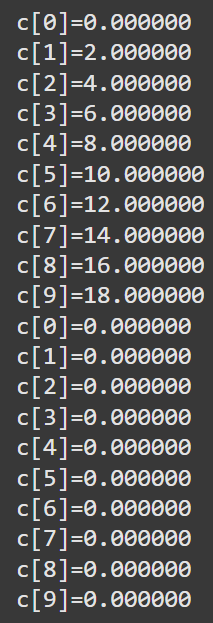

In [ ]:
!./CudaTestrun.out

c[0]=0.000000
c[1]=2.000000
c[2]=4.000000
c[3]=6.000000
c[4]=8.000000
c[5]=10.000000
c[6]=12.000000
c[7]=14.000000
c[8]=16.000000
c[9]=18.000000
c[0]=0.000000
c[1]=2.000000
c[2]=4.000000
c[3]=6.000000
c[4]=8.000000
c[5]=10.000000
c[6]=12.000000
c[7]=14.000000
c[8]=16.000000
c[9]=18.000000


nvprof - profile performance of GPU

In [ ]:
!nvprof ./CudaTestrun.out

c[0]=0.000000
c[1]=2.000000
c[2]=4.000000
c[3]=6.000000
c[4]=8.000000
c[5]=10.000000
c[6]=12.000000
c[7]=14.000000
c[8]=16.000000
c[9]=18.000000
==745== NVPROF is profiling process 745, command: ./CudaTestrun.out
c[0]=0.000000
c[1]=2.000000
c[2]=4.000000
c[3]=6.000000
c[4]=8.000000
c[5]=10.000000
c[6]=12.000000
c[7]=14.000000
c[8]=16.000000
c[9]=18.000000
==745== Profiling application: ./CudaTestrun.out
==745== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   64.98%  3.6284ms         2  1.8142ms  1.8127ms  1.8157ms  [CUDA memcpy HtoD]
                   33.37%  1.8631ms         1  1.8631ms  1.8631ms  1.8631ms  [CUDA memcpy DtoH]
                    1.65%  91.997us         1  91.997us  91.997us  91.997us  vectorAdditionKernel(double*, double*, double*, int)
      API calls:   91.81%  87.813ms         3  29.271ms  131.70us  87.530ms  cudaMalloc
                    6.76%  6.4615ms         3  2.1538ms  1.9890ms  2.4252ms